# Chainer Test MNIST (CNN)
* CNNでMNISTを解くプログラムを書いてみる
* chainer v1.6

In [1]:
%matplotlib inline

In [2]:
import sys, os
import numpy as np
import pandas as pd

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import six

import matplotlib.pyplot as plt

import data

## GPUの設定

In [3]:
gpu_flag = 2

In [4]:
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのダウンロード
* 28×28ピクセル、[0,1]の値に変換

In [5]:
mnist = data.load_mnist_data()

In [6]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2, 2))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

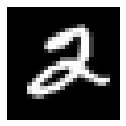

In [7]:
draw_digit(mnist['data'][5])

### データの前処理

In [8]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

# 0-1の範囲に正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

In [9]:
x_train.max()

1.0

In [10]:
# chainerで扱うデータ型に変換
x_train=x_train.astype(xp.float32)
y_train=y_train.astype(xp.int32)

In [11]:
x_train.dtype

dtype('float32')

In [12]:
# 画像を (nsample, channel, height, width) の4次元テンソルに変換
X_train = x_train.reshape((len(x_train), 1, 28, 28))
X_test = x_test.reshape((len(x_test), 1, 28, 28))

In [14]:
x_train.shape

(60000, 784)

## モデルの定義
* ネットワーク構造については以下のページがわかりやすい
http://aidiary.hatenablog.com/entry/20151007/1444223445

In [ ]:
class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            conv1=F.Convolution2D(1, 32, 6, stride=1, pad=1),
            conv2=F.Convolution2D(32, 64, 6, stride=1, pad=1),
            l3=F.Linear(30976, 10), 
        )
        
    def __call__(self, x):
        # chainの定義
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        y = self.l3(h)
        return y

# Optimizerの定義

In [ ]:
model = L.Classifier(MLP())
## ^ Classifierクラスにモデルを渡している
## これで、ロス関数を定義していることになる。Classifierだから、softmax_cross_entropy
optimizer = optimizers.SGD()
optimizer.setup(model)

if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()

# 学習

In [ ]:
batchsize = 100
epochN = 20
datasize = N

In [ ]:
acc_arr = []
loss_arr = []
print('epoch \t loss \t accuracy')
for epoch in range(epochN):
    sum_loss=0
    sum_accuracy = 0
    indexes = np.random.permutation(datasize)
    for i in six.moves.range(0, datasize, batchsize):
        ## GPU使う時にハマった部分
        # ちゃんとVariable型に変換しとかないとエラーが出るよ
        # xp.asarray でarrayにしておかないとエラーが出るよ
        x = Variable(xp.asarray(X_train[indexes[i : i + batchsize]]))
        t = Variable(xp.asarray(y_train[indexes[i : i + batchsize]]))
        
        model.zerograds()
        loss = model(x, t)
        loss.backward()
        optimizer.update()
        
        sum_loss += loss.data * len(t.data)
        sum_accuracy += model.accuracy.data * len(t.data)
    print('%s \t %s \t %s'%(epoch, sum_loss/datasize, sum_accuracy/datasize))
    acc_arr.append(float(sum_accuracy)/datasize)
    loss_arr.append(float(sum_loss)/datasize)

## 学習曲線をプロットする

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(len(acc_arr)), acc_arr, color="#FF0000")
#plt.legend(["accuracy"],loc=4)
plt.title("accuracy")

plt.subplot(1,2,2)
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
#plt.legend(["loss"],loc=4)
plt.title("loss")

plt.plot()